# Analyzing my spotify listening history - Part 1
> Soul searching through my choices in music

- toc: true
- branch: master
- badges: true
- comments: true
- author: Bauke Brenninkmeijer
- categories: [Analysis, Music]

I like to have everything in my life tracked in some way. Preferably, knowingly (Looking at you, Facebook), cause it allows you to analyze it and find interesting things (Might be related with becoming a data scientist)! I've always been a fan of the features provided by [Last.fm](https://www.last.fm) to track you listening behaviour across apps and platforms. It allows you to see stuff like your favorite artists per month, or your afinity with certain genres over time like in the image below.

![Your top genres, plotted per week.](images/genre-timeline-lastfm.png "Your top genres, plotted per week. Source: Last.fm")

_Buuuuuut_, like Last.fm, most of these analyses are paid completely or partly. In the case of Last.fm, you get this plot for free but anything more will cost you some paper. I'm kinda cheap, so let's see if we can do it ourselves!

I wanted to have my listening history, and currently there is an [API call](https://developer.spotify.com/documentation/web-api/reference/player/get-recently-played/) that provides that functionality. However, I wanted to do this at the start of 2019 (Yeah, I didn't get around to doing this until now 😅) and this wansn't available back then, or at least I couldn't find it. Spotify, like many other companies, has an option to download your personal information. Unfortunately, this data only contained data for three months (they upped it to a year now, which is great!). 

But, given this limitation, **the only way I could think of to get this was to ask Spotify for my personal data**. Under the GDPR, they are required to provide this information, so I thought this had a good shot. Well, after e-mailing back and forth a whole bunch of times, eventually I got in touch with the Data Privacy Office and they provided me with my complete listening history! 

So that's the data that we'll be working with. Like I said, I requested the data in early 2019, so my history goes from my beginning of Spotify (ca. 2013) untill then. So lets see what we're dealing with. 

In [11]:
#hide
import ast
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm_notebook
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json_lines
import altair as alt
from tqdm.auto import tqdm
%matplotlib inline

I received one main file from spotify called `EndSong.json` which had json items as follows. In total, I got 39,229 songs played, which is quite a lot and definitely enough to do some interesting things with!

```json
{
    "ts":"2013-10-09 20:03:57 UTC",
    "username":"xxxxxxxxxx",
    "platform":"xxxxxxx",
    "ms_played":"5969",
    "conn_country":"NL",
    "ip_addr_decrypted":"xx.xx.xx.xx",
    "user_agent_decrypted": "xxxxxxxxxxx",
    "master_metadata_track_name":"You Make Me",
    "master_metadata_album_artist_name":"Avicii",
    "master_metadata_album_album_name":"You Make Me",
    "reason_start":"click-row",
    "reason_end":"click-row",
    "shuffle":false,
    "skipped":false,
    "offline":false,
    "offline_timestamp":"0",
    "incognito_mode":false,
    "metro_code":"0",
    "longitude":0,
    "latitude":0
}
```

For our analysis, we're gonna use the ol' trusty [Pandas](https://pandas.pydata.org/). The data is in the json-lines format, so we use the python [json-lines](https://pypi.org/project/json-lines/) package to read our data. We'll also drop some useless columns and convert the timestamp column to a python datetime object. Furthermore, we use the UTF-8 encoding while reading our data, to support tokens that would otherwise be malformed like the ë character. Lastly, we also create separate columns for many of our time attributes like year, month and day, since this makes it easy for filtering during plotting. 

> Tip: The json-lines format puts a json object on each separate line, and allows for very dense information packaging in json files. Before I knew this, I was reading the data as a string, converting true->True and false->False, to match python syntax and then using the ast package to interpret the string as a python object. That also worked ok, but this is much better. 😊

In [2]:
lines = []
for i in json_lines.reader(open('data/EndSong.json', encoding='utf-8')):
    lines.append(i)
df = pd.DataFrame(lines)

In [3]:
#collapse-hide
df = df.drop(['username', 'user_agent_decrypted', 'incognito_mode', 'platform', 'ip_addr_decrypted'], axis=1)
df.ts = pd.to_datetime(df.ts)
df['date'] = df.ts.dt.date
df['year'] = df.ts.dt.year
df['month'] = df.ts.dt.month
df['day'] = df.ts.dt.day
df['dow'] = df.ts.dt.dayofweek
df['hour'] = df.ts.dt.hour
df.head(4)

,ts,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,reason_start,reason_end,shuffle,skipped,...,city,region,episode_name,episode_show_name,date,year,month,day,dow,hour
0,2013-10-09 20:24:30+00:00,15010,NL,Wild for the Night (feat. Skrillex & Birdy Nam...,A$AP Rocky,LONG.LIVE.A$AP (Deluxe Version),unknown,click-row,False,False,...,NaN,NaN,NaN,NaN,2013-10-09,2013,10,9,2,20
1,2013-10-09 20:19:20+00:00,68139,NL,Buzzin',OVERWERK,The Nthº,unknown,click-row,False,False,...,NaN,NaN,NaN,NaN,2013-10-09,2013,10,9,2,20
2,2013-10-09 20:21:54+00:00,23643,NL,Blue,Gemini,Blue EP,unknown,click-row,False,False,...,NaN,NaN,NaN,NaN,2013-10-09,2013,10,9,2,20
3,2013-10-09 20:20:29+00:00,68063,NL,Blue,Gemini,Blue EP,unknown,click-row,False,False,...,NaN,NaN,NaN,NaN,2013-10-09,2013,10,9,2,20


## Yearly behaviour

One of the first things I'm curious to see is how my usage of spotify has changed over the years. For this, we can easily plot the number of songs player by year and by month. 

> Note: All my plots will be created using Altair. This is mainly because [fastpages](https://github.com/fastai/fastpages) has the best support for this. But, I have taken this opportunity to become really familiar with the nooks and crannies of Altair. My previous go-tos are and likely still will be for most: matplotlib and seaborn. 

In [4]:
#hide
alt.vegalite.v4.theme.VEGA_THEMES

['ggplot2',
 'quartz',
 'vox',
 'fivethirtyeight',
 'dark',
 'latimes',
 'urbaninstitute']

We're using the _fivethirtyeight_ vega lite theme. We can set altair to use this with the following line. 

In [5]:
alt.themes.enable('fivethirtyeight')

ThemeRegistry.enable('fivethirtyeight')

In [30]:
#hide
MAXWIDTH = 640

In [31]:
#collapse-hide
t = (
    df.ts.dt  # Use the datetime attributes of the ts column
    .to_period('D')  # Convert the ts column to a 'date' period. So the timestamp is reduced to a date like '28-2-2020'.
    .value_counts()  # Counts the frequency of all days (i.e. count how many songs were played that day).
    .to_timestamp()  # The index is a RangeIndex after the `to_period`, so we convert it back to a datetime.
    .to_frame()      # Altair wants dataframes, so we convert it to a dataframe.
    .reset_index()   # Make the datetime index a separate column instead of the index. 
    .rename(columns={'index': 'date', 'ts': 'listens'})  # Rename the columns to be descriptive
)

yearly = alt.Chart(t).mark_bar(size=30).encode(
    alt.X('year(date):O', title='Year'),
    alt.Y('sum(listens):Q', title='Listens'),
    tooltip=['sum(listens)', 'year(date)']
).properties(width=MAXWIDTH/2)

monthly = alt.Chart(t).mark_bar().encode(
    alt.X('yearmonth(date):T', title='Month'),
    alt.Y('sum(listens):Q', title='Listens'),
    tooltip=['sum(listens)', 'yearmonth(date)'],
).properties(width=MAXWIDTH/2)

# Altair allows really easy formatting, having horizontal concatenation with the | operator
yearly | monthly

alt.HConcatChart(...)

In the plots above you see my total songs listened. It immediately becomes clear that I got my data in early 2019, given the drop in 2019 and lack of data in 2020. But what is interesting is the steady increasing line the previous years. It shows that I slowly started using spotify more and more. The start coincides with when I started paying for Spotify as well, which is not very surprising (Yay for no ads and song selection 💯). 

When looking at the number of songs per month, we can still see a decline in listening activity since the spike at October 2018. The peak that ranges from September 2018 to November 2018 can be explained by me starting a new internship where I was playing spotify while working the whole day. In October my total songs listened more than doubled compared to only two months earlier (1615 to 3273 songs played).

Furthermore, we can see that I also used Spotify for a short while in 2016, but stopped using it again for about a year. Then I picked it up again in 2017 and never stopped using it afterwards. 

## Daily behaviour
Well, I'm already learning a lot about Altair, cause creating this plot in its current form easily took three hours. Altair does not like it when you aggregate a value in several places. _But_ the result is also quite a nice visual. I plotted the daily distribution per hours per year. Now, the value is the sum of the whole year, so it's no wonder that the differences are really similar to what we say in the yearly distribution. More interesting would be the percentage per hour per year, which would tell me something about my listening behaviour throughout the years. 

_The yearly visuals only show 2016 till 2019, because the others years don't have enough data._

There are several noteworthy things:
1. **In 2016**, there was a big spike between 13:00 and 14:00. 2016 is split between my third and fourth year at university, of which in the fourth year I also was on the board of the [e-sports association](https://dorans.nl/). I just barely didn't have enough credits to get my bachelor's degree in my third year, so my fourth year was pretty empty. The combination likely contributed to many days where I had lunch and then closed myself of with music, to work on association matters. 
3. **In 2016**, there is a big spike at 9:00. This makes sense, because that was always the time I was cycling to my university. Over the years, I started listening to podcasts more, which is why you can see the 9:00 value decline over 4 years. 
2. **In 2018 and 2019**, my listening during evening hours decreased quite significantly. Earlier, I had a spike at 22:00 but this completely faded during the first month of 2019. What happened? Not sure, to be frank. It might be that I had more nights planned with friends? 
4. **In 2017 and 2018**, I somehow play 4% of my music daily before 7:00. Now, this is essentially impossible since I almost never get up before 7. I'm not sure why this is shown to be the case. 

> Tip: I've since learned that you can so things like define variables and aggregate values in Altair. An example can be found here: https://altair-viz.github.io/gallery/percentage_of_total.html. However, did not go back and redo the analyses using that. That's for another time. 😉

In [7]:
#hide
# hourly_data = (
#     df.ts.dt  # Use the datetime attributes of the ts column
#     .to_period('H')  # Convert the ts column to a 'hour' period. So the timestamp is reduced to a date like '28-2-2020 14:00'.
#     .value_counts()  # Counts the frequency of all these values (i.e. count how many songs were played that day).
#     .to_timestamp()  # The index is a RangeIndex after the `to_period`, so we convert it back to a datetime.
#     .to_frame()      # Altair wants dataframes, so we convert it to a dataframe.
#     .reset_index()   # Make the datetime index a separate column instead of the index. 
#     .rename(columns={'index': 'datetime', 'ts': 'listens'})  # Rename the columns to be descriptive
# )


# hourly_data['year'] = hourly_data.datetime.dt.year
# hourly_data['hour'] = hourly_data.datetime.dt.hour


In [16]:
#hide_input
# Create sum per hour per year
selection_sum = df.groupby(['year', 'hour']).size().reset_index().rename(columns={0: 'count'})

# Create percentage per hour per year
selection_perc = selection_sum.copy()
yearly_counts = df.ts.dt.to_period('Y').value_counts()
for year in yearly_counts.index:
    selection_perc.loc[selection_perc.year == year.year, 'count'] = selection_perc.loc[selection_perc.year == year.year, 'count'] / yearly_counts[year.year]
selection_perc = selection_perc.round(2)

# Plot the total listens per hour
total = alt.Chart(selection_sum).mark_bar().encode(
    alt.X('hour:O', title='Hour'),
    alt.Y('sum(count):Q', title='Listens'),
).properties(title='Sum of listens per hour')


label = alt.selection_single(
    encodings=['x'], # limit selection to x-axis value
    on='mouseover',  # select on mouseover events
    nearest=True,    # select data point nearest the cursor
    empty='none'     # empty selection includes no data points
)

monthly = alt.Chart().mark_line().encode(
    alt.X('hour:O', title='Hour'),
    alt.Y('count:Q', title='Listens'),
    color='year:N',
).transform_filter(alt.FieldOneOfPredicate(field='year', oneOf=[2016, 2017, 2018, 2019]))

# Plot sum per hour per year
sum_per_hour_per_year = alt.layer(
    monthly.properties(
        title='Sum of listens per hour per year'
    ), # base line chart
    
#     add a rule mark to serve as a guide line
    alt.Chart().mark_rule(color='#aaa').encode(
#         alt.X('hour'),
        x='hour:O'
    ).transform_filter(label),
    
    # add circle marks for selected time points, hide unselected points
    monthly.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
    
#     # add white stroked text to provide a legible background for labels
    monthly.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='sum(count):Q'
    ).transform_filter(label),
    
    # add text labels for stock prices
    monthly.mark_text(align='left', dx=5, dy=-5).encode(
        alt.Text('sum(count):Q'),
#         text='sum(listens):Q'
    ).transform_filter(label),
    
    data = selection_sum
).properties(
    width=400,
    height=300
)

# Plot percentage per hour per year
perc_per_hour_per_year = alt.layer(
    monthly.properties(
        title='Percentage of listens per hour per year'
    ),     
    alt.Chart().mark_rule(color='#aaa').encode(
        x='hour:O'
    ).transform_filter(label),
    
    monthly.mark_circle().encode(
        opacity=alt.condition(label, alt.value(1), alt.value(0))
    ).add_selection(label),
    
    monthly.mark_text(align='left', dx=5, dy=-5, stroke='white', strokeWidth=2).encode(
        text='sum(count):Q'
    ).transform_filter(label),
    
    monthly.mark_text(align='left', dx=5, dy=-5).encode(
        alt.Text('sum(count):Q'),
    ).transform_filter(label),
    
    data = selection_perc
).properties(
    width=400,
    height=300
)

total | sum_per_hour_per_year | perc_per_hour_per_year

alt.HConcatChart(...)

# Genres
Now that we have some insight into my listening behaviour, we can analyze what I listen to a bit more closely. For example, what genres do I listen to most and how do these change? Here we get a bit closer to the visualization we got from Last.fm.

However, before we can do that, we need to get the genres associated with our songs. This was not included in the data Spotify sent over, so we need to use their API to get this information. Spotify does not apply categories per song, but rather per artist. Internally, Spotify uses special URIs to indicate different concepts like artists, songs and albums. For example, a track can be indicated with `spotify:track:6rqhFgbbKwnb9MLmUQDhG6`. 

These URIs refer to a specific object, whereas the artist in the data I received does not. So we need to use the Spotify search function to retrieve the correct Spotify object of an artist, and then we can retrieve the genres from there. Now, either the data they sent is somewhat corrupted or their music management is a bit lackluster, because there were still quite some artists without an Spotify URI and/or without any defined genres. The latter makes sense, since this takes a lot of work by spotify. 

You can see the API calls and retrieval loop I used in the two collapsed cells below. 

In [9]:
#collapse-hide
SPOTIFY_API_KEY = os.getenv('SPOTIFY_API_KEY')
SPOTIFY_CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
spotify_search_url = 'https://api.spotify.com/v1/search?q={q}&type={type}'
spotify_headers = {"Accept": "application/json", "Authorization":"Bearer " + SPOTIFY_API_KEY, "Content-Type": "application/json"}
client_credentials_manager = SpotifyClientCredentials(SPOTIFY_CLIENT_ID, SPOTIFY_API_KEY)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
#collapse-hide
artist_ids = []
genres = []
for artist in tqdm(df.master_metadata_album_artist_name):
    try:
        response = spotify.search(artist, type='artist')
        artist_id = response.get('artists').get('items')[0].get('uri')
        artist_genres = response.get('artists').get('items')[0].get('genres')
    except Exception as e:
        print(e)
        print(response)
        artist_id = ''
        artist_genres = []
    genres.append(artist_genres)
    artist_ids.append(artist_id)
print(len(artist_ids), len(genres))
genres_df = pd.DataFrame(genres)
artist_ids_df = pd.DataFrame(artist_ids)

In [12]:
#hide
genres_df = pd.DataFrame(genres)
genres_df.to_csv('genres.csv', index=False)

artist_ids_df = pd.DataFrame(artist_ids)
artist_ids_df.to_csv('artist_ids.csv', index=False)

In [13]:
#hide
genres_df = pd.read_csv('genres.csv', low_memory=False)
artist_ids_df = pd.read_csv('artist_ids.csv', low_memory=False)

EmptyDataError: No columns to parse from file

Let's have a short look at the data. 

In [ ]:
#hide_input
genres_df.head(2)

Because we added all genres for each artist as a new column, we have quite a wide dataframe. The artist with the most genres has 21(!) genres. Let's see who that is. 

In [ ]:
comb = pd.concat([df, genres_df], axis=1)
comb.loc[~(comb['20'].isna())]

It's some artist called Pavement! I've no idea who that is, but still interesting to see. The artist seems to be in the indie rock segment, where there are many subgenres, so it's not that surprising. I've heard that metal has a similar amount of subgenres, so it would be cool to do this analysis for a metal fan 🤘. 

But, clearly I am not in that segment. Lets see how many genres an average artist of mine has. We'll exclude artists with zero genres. 

In [92]:
#hide_input
genre_count_per_artist = comb.drop_duplicates(['master_metadata_album_artist_name']).copy()
tmp = genre_count_per_artist.loc[:, [str(x) for x in range(21)]].count(axis=1)
genre_count_per_artist.loc[:, 'genre_count'] = tmp.astype(int)
genre_count_per_artist = genre_count_per_artist[genre_count_per_artist.genre_count > 0]

alt.Chart(genre_count_per_artist[['genre_count']]).mark_bar(width=13).encode(
    alt.X('genre_count'),
    y='count()',
    tooltip=['genre_count', 'count()']
).properties(title='Numer of genres per artist')

alt.Chart(...)

If we take the percentage of the artists with three or less genres, we see this is 52%. This is quite high, and means many people are pretty specific with regards to what genres they fall into for Spotify. 

What genres are they, though? That is the big question. Let's see!

In [17]:
#hide_input
top_genres = (
    genres_df.apply(pd.Series.value_counts)
    .apply(np.sum, axis=1)
    .sort_values(ascending=False)[:10]
    .reset_index()
    .rename(columns={'index': 'genre', 0: 'count'})
)

alt.Chart(top_genres).mark_bar().encode(
    x='count', 
    y=alt.Y('genre', sort='-x'),
    tooltip=['count'],
).properties(title='Listens per genre')

alt.Chart(...)

In [11]:
top_genres_5 = top_genres[:10].index.values
top_genres_5

array(['rap', 'hip hop', 'pop rap', 'edm', 'pop', 'electro house',
       'electronic trap', 'brostep', 'house', 'bass trap'], dtype=object)

In [14]:
from itertools import product
from tqdm.auto import tqdm

In [15]:
counters_per_month = []
for year, month in product(df.year.sort_values().unique(), df.month.sort_values().unique()):
    if len(df.loc[(df.year == year) & (df.month == month)]) > 0:
        for i, row in df.loc[(df.year == year) & (df.month == month)].iterrows():
            for genre in row.top_genres:
                counter = {'year': year, 'month': month}
                counter[genre] = counter.get(genre, 0) + 1
        counters_per_month.append(counter)

In [38]:
counts_per_genre_per_month = pd.DataFrame(counters_per_month)

In [39]:
monthly_sum = df.groupby(['year', 'month']).size().reset_index().rename(columns={0: 'count'})

In [40]:
for i, row in monthly_sum.iterrows():
    counts_per_genre_per_month.loc[(counts_per_genre_per_month.year == row.year) & (counts_per_genre_per_month.month == row.month), top_genres_5] = counts_per_genre_per_month.loc[(counts_per_genre_per_month.year == row.year) & (counts_per_genre_per_month.month == row.month), top_genres_5] / row['count']

In [41]:
counts_per_genre_per_month = counts_per_genre_per_month.loc[(counts_per_genre_per_month.year > 2016) | ((counts_per_genre_per_month.year == 2016) & (counts_per_genre_per_month.month > 8))]

In [134]:
counts_per_genre_per_month.iloc[:1, :]

,year,month,hip hop,pop,pop rap,rap,edm,electro house,brostep,bass trap,electronic trap,house
16,2016,9,0.449612,0.387597,0.488372,0.51938,0.100775,0.054264,0.015504,0.007752,0.031008,0.054264


In [43]:
counts_per_genre_per_month_melted = pd.melt(counts_per_genre_per_month, id_vars=['year', 'month'], value_vars=['hip hop', 'pop', 'pop', 'rap', 'rap', 'edm', 'electro house', 'brostep', 'bass trap', 'electronic trap', 'house'], var_name='genre', value_name='percentage')

In [44]:
counts_per_genre_per_month_melted['datetime'] = pd.to_datetime(counts_per_genre_per_month_melted.month.astype(str) + '-' + counts_per_genre_per_month_melted.year.astype(str), format='%m-%Y')

In [55]:
alt.Chart(counts_per_genre_per_month_melted).mark_bar().encode(
    x=alt.X('yearmonth(datetime)'),
    y=alt.Y('percentage', stack='normalize'),
    color='genre'
)

alt.Chart(...)

In [128]:
def top_n_genres_per_month_as_list(df, top_n=5):
    """
    From a dataframe with a numerical value for each genre, sort the genres on this value and extract the `top_n` genres. 
    Add these values again to a list of dictionaries, and put it in a dataframe. 
    """
    rows = []
    for i, row in counts_per_genre_per_month.iterrows():
        new_row = {'year': row.year, 'month': row.month}
        top_genres_this_month = [k for k, v in sorted(row[top_genres_5].to_dict().items(), key=lambda item: item[1], reverse=True)][:top_n]
        new_row = {**new_row, **{i: k for i, k in enumerate(top_genres_this_month)}}
        rows.append(new_row)
    return pd.DataFrame(rows)

In [129]:
top_n_genres_per_month_df = top_n_genres_per_month_as_list(counts_per_genre_per_month)
top_n_genres_per_month_df[['year', 'month']] = top_n_genres_per_month_df[['year', 'month']].astype(int)
top_n_genres_per_month_df = top_n_genres_per_month_df.loc[top_n_genres_per_month_df.year >= 2018]
top_n_genres_per_month_df = top_n_genres_per_month_df.set_index(['year', 'month']).T

In [130]:
def color_cells(val):
    """
    Takes a cell value and applies coloring depending on the value. Should be applied to a cell, not a row. So use `.applymap`. 
    """
    colors = {'rap': 'red', 'pop': 'lightblue', 'hip hop': 'orange', 'edm': 'yellow', 'electro house': 'cyan', 'house': 'magenta', 'pop rap': 'lightgreen'}
    color = colors.get(val, 'white')
    return f'background-color: {color}'

In [131]:
top_n_genres_per_month_df.style.applymap(color_cells)

In [10]:
track_ids = []
for track in tqdm_notebook(df.master_metadata_track_name):
    try:
        response = spotify.search(track.split(' ')[:2], type='track', limit=1)
        track_id = response.get('tracks').get('items')[0].get('uri')
#         artist_genres = response.get('artists').get('items')[0].get('genres')
    except Exception as e:
        print(e)
        print(track)
        track_id = ''
    track_ids.append(track_id)
print(len(track_ids))

'float' object has no attribute 'split'
nan
'float' object has no attribute 'split'
nan
'float' object has no attribute 'split'
nan
list index out of range
ÐÐ°Ð²Ð°Ð¹ Ð¾ÑÑÐ°Ð½ÐµÐ¼ÑÑ Ð´Ð¾Ð¼Ð°
list index out of range
Sneakinâ
list index out of range
Schoolfeest
list index out of range
OdyssÃ©e
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Witlof
list index out of range
Funkmasterflex - Freestyle
list index out of range
Funkmasterflex - Freestyle
list index

In [11]:
pd.Series(track_ids).to_csv('track_ids.csv', index=False)

In [8]:
track_ids = pd.read_csv('track_ids.csv')

In [26]:
len(track_ids)

39229

In [14]:
spotify.audio_analysis(track_ids[0]).keys()

dict_keys(['meta', 'track', 'bars', 'beats', 'tatums', 'sections', 'segments'])

In [ ]:
spotify.audio_analysis(track_ids[0])

In [23]:
spotify.audio_features([track_ids[0], track_ids[1]])

[{'danceability': 0.613,
  'energy': 0.681,
  'key': 8,
  'loudness': -3.089,
  'mode': 1,
  'speechiness': 0.0778,
  'acousticness': 0.0287,
  'instrumentalness': 0,
  'liveness': 0.126,
  'valence': 0.619,
  'tempo': 97.621,
  'type': 'audio_features',
  'id': '45XhKYRRkyeqoW3teSOkCM',
  'uri': 'spotify:track:45XhKYRRkyeqoW3teSOkCM',
  'track_href': 'https://api.spotify.com/v1/tracks/45XhKYRRkyeqoW3teSOkCM',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/45XhKYRRkyeqoW3teSOkCM',
  'duration_ms': 204664,
  'time_signature': 4},
 {'danceability': 0.563,
  'energy': 0.463,
  'key': 9,
  'loudness': -9.249,
  'mode': 0,
  'speechiness': 0.4,
  'acousticness': 0.65,
  'instrumentalness': 4.87e-06,
  'liveness': 0.0967,
  'valence': 0.276,
  'tempo': 149.571,
  'type': 'audio_features',
  'id': '6WUgEQwCbnaPrLf9V5K4HG',
  'uri': 'spotify:track:6WUgEQwCbnaPrLf9V5K4HG',
  'track_href': 'https://api.spotify.com/v1/tracks/6WUgEQwCbnaPrLf9V5K4HG',
  'analysis_url': 'https://api.sp

In [86]:
track_features = []
for track in tqdm_notebook(df.master_metadata_track_name):
    try:
        response = spotify.search(track.split(' ')[:2], type='track', limit=1)
        track_id = response.get('tracks').get('items')[0].get('uri')
#         artist_genres = response.get('artists').get('items')[0].get('genres')
    except Exception as e:
        print(e)
        print(track)
        track_id = ''
    track_features.append(track_id)
print(len(track_ids))

In [23]:
track_features = []
import math
for i in tqdm_notebook(range(0, len(track_ids))):
    if track_ids[i] == '':
        track_features_temp = None
    if isinstance(track_ids[i], float):
        if math.isnan(track_ids[i]):
            print('isnan')
            track_features_temp = None
    else:
        try:
            track_features_temp = spotify.audio_features(track_ids[i])
        except Exception as e:
            print(e)
            print(track_ids[i])
    track_features += track_features_temp if track_features_temp else [None]
print(len(track_features))

isnan
isnan
isnan
retrying ...4secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
isnan
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
isnan
isnan
isnan
retrying ...3secs
retrying ...1secs
retrying ...3secs
retrying ...1secs
isnan
isnan
isnan
isnan
isnan
isnan
isnan
isnan
isnan
isnan
isnan
retrying ...1secs
isnan
isnan
isnan
isnan
isnan
isnan
isnan
retrying ...3secs
retrying ...1secs
isnan
isnan
isnan
isnan
isnan
retrying ...2secs
retrying ...1secs
isnan
isnan
isnan
retrying ...1secs
isnan
isnan
isnan
retrying ...2secs
retrying ...2secs
retrying ...1secs
isnan
retrying ...3secs
retrying ...1secs
isnan
retrying ...1secs
retrying ...1secs
isnan
isnan
retrying ...2secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...1secs
retrying ...2secs
isnan
retrying ...4secs
retrying ...1secs
retrying ...4secs
retrying ...1secs
retrying ...4secs
retrying ...1secs
retrying ...1secs
isnan
isnan
isna

In [25]:
pd.Series(track_features).to_csv('track_features.csv', index=False)

In [ ]:
track_features = pd.Series.from_csv('track_features.csv')

In [38]:
for x in tqdm(range(len(track_features))):
    filler = {'danceability': None,
  'energy': None,
  'key': None,
  'loudness': None,
  'mode': None,
  'speechiness': None,
  'acousticness': None,
  'instrumentalness': None,
  'liveness': None,
  'valence': None,
  'tempo': None,
  'type': None,
  'id': None,
  'uri': None,
  'track_href': None,
  'analysis_url': None,
  'duration_ms': None,
  'time_signature': None}
    if track_features[x] is None:
        track_features[x] = filler
    if isinstance(track_ids[i], float):
        if math.isnan(track_ids[i]):
            track_features[x] = filler


In [41]:
track_features_df = pd.DataFrame(track_features)

In [42]:
track_features_df.to_csv('track_features_df.csv')

In [18]:
track_features_df = pd.read_csv('track_features_df.csv').drop('Unnamed: 0', axis=1)

In [20]:
track_features_df.columns

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')

In [51]:
track_features_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,38131.000000,38131.000000,3.813100e+04,38131.000000,38131.000000,38131.000000,38131.000000,38131.000000,38131.000000,38131.000000,38131.000000,38131.000000,38131.000000
mean,0.229174,0.670798,2.153865e+05,0.614641,0.065760,4.709606,0.181568,-7.256677,0.597362,0.126330,121.241460,3.927277,0.449313
std,0.267589,0.159116,6.585594e+04,0.194569,0.210722,3.524272,0.140825,3.866346,0.490436,0.119944,30.038514,0.387834,0.230882
min,0.000000,0.000000,3.105200e+04,0.000020,0.000000,0.000000,0.000000,-54.376000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.027700,0.573000,1.794490e+05,0.498000,0.000000,1.000000,0.092600,-8.364000,0.000000,0.044900,96.062000,4.000000,0.273000
50%,0.107000,0.681000,2.060000e+05,0.620000,0.000001,5.000000,0.121000,-6.495000,1.000000,0.070500,122.961000,4.000000,0.433000
75%,0.356000,0.791000,2.398360e+05,0.745000,0.000355,8.000000,0.229000,-5.107000,1.000000,0.176000,144.004000,4.000000,0.619000
max,0.996000,0.974000,3.391040e+06,1.000000,0.997000,11.000000,0.979000,0.428000,1.000000,0.954000,216.429000,5.000000,0.989000


In [55]:
from pandas_summary import DataFrameSummary
DataFrameSummary(track_features_df).summary()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
count,38131,NaN,38131,38131,38131,NaN,38131,38131,38131,38131,38131,38131,38131,38131,NaN,NaN,NaN,38131
mean,0.229174,NaN,0.670798,215387,0.614641,NaN,0.0657602,4.70961,0.181568,-7.25668,0.597362,0.12633,121.241,3.92728,NaN,NaN,NaN,0.449313
std,0.267589,NaN,0.159116,65855.9,0.194569,NaN,0.210722,3.52427,0.140825,3.86635,0.490436,0.119944,30.0385,0.387834,NaN,NaN,NaN,0.230882
min,0,NaN,0,31052,1.99e-05,NaN,0,0,0,-54.376,0,0,0,0,NaN,NaN,NaN,0
25%,0.0277,NaN,0.573,179449,0.498,NaN,0,1,0.0926,-8.364,0,0.0449,96.062,4,NaN,NaN,NaN,0.273
50%,0.107,NaN,0.681,206000,0.62,NaN,1.21e-06,5,0.121,-6.495,1,0.0705,122.961,4,NaN,NaN,NaN,0.433
75%,0.356,NaN,0.791,239836,0.745,NaN,0.000355,8,0.229,-5.107,1,0.176,144.004,4,NaN,NaN,NaN,0.619
max,0.996,NaN,0.974,3.39104e+06,1,NaN,0.997,11,0.979,0.428,1,0.954,216.429,5,NaN,NaN,NaN,0.989
counts,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131,38131
uniques,1949,3873,767,3665,932,3873,1642,12,999,3257,2,1055,3561,5,3873,1,3873,1052


In [56]:
track_features_df.dropna(subset=['energy', 'danceability'])

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.028700,https://api.spotify.com/v1/audio-analysis/45Xh...,0.613,204664.0,0.681,45XhKYRRkyeqoW3teSOkCM,0.000000,8.0,0.1260,-3.089,1.0,0.0778,97.621,4.0,https://api.spotify.com/v1/tracks/45XhKYRRkyeq...,audio_features,spotify:track:45XhKYRRkyeqoW3teSOkCM,0.6190
1,0.650000,https://api.spotify.com/v1/audio-analysis/6WUg...,0.563,183287.0,0.463,6WUgEQwCbnaPrLf9V5K4HG,0.000005,9.0,0.0967,-9.249,0.0,0.4000,149.571,4.0,https://api.spotify.com/v1/tracks/6WUgEQwCbnaP...,audio_features,spotify:track:6WUgEQwCbnaPrLf9V5K4HG,0.2760
2,0.018300,https://api.spotify.com/v1/audio-analysis/2oPC...,0.455,212067.0,0.897,2oPCR02nduYVpj7CTfsA0d,0.000000,9.0,0.1740,-4.879,1.0,0.0403,160.139,4.0,https://api.spotify.com/v1/tracks/2oPCR02nduYV...,audio_features,spotify:track:2oPCR02nduYVpj7CTfsA0d,0.7280
3,0.018300,https://api.spotify.com/v1/audio-analysis/2oPC...,0.455,212067.0,0.897,2oPCR02nduYVpj7CTfsA0d,0.000000,9.0,0.1740,-4.879,1.0,0.0403,160.139,4.0,https://api.spotify.com/v1/tracks/2oPCR02nduYV...,audio_features,spotify:track:2oPCR02nduYVpj7CTfsA0d,0.7280
4,0.407000,https://api.spotify.com/v1/audio-analysis/3Ol2...,0.791,179449.0,0.587,3Ol2xnObFdKV9pmRD2t9x8,0.000000,3.0,0.1480,-5.075,0.0,0.0413,96.057,4.0,https://api.spotify.com/v1/tracks/3Ol2xnObFdKV...,audio_features,spotify:track:3Ol2xnObFdKV9pmRD2t9x8,0.5360
5,0.013700,https://api.spotify.com/v1/audio-analysis/1dFk...,0.609,243413.0,0.801,1dFkD1JfRMzwO6hwUsE8aS,0.003490,0.0,0.1270,-4.417,0.0,0.0340,129.990,4.0,https://api.spotify.com/v1/tracks/1dFkD1JfRMzw...,audio_features,spotify:track:1dFkD1JfRMzwO6hwUsE8aS,0.4070
6,0.280000,https://api.spotify.com/v1/audio-analysis/2rPE...,0.724,207333.0,0.647,2rPE9A1vEgShuZxxzR2tZH,0.000000,1.0,0.1020,-5.642,1.0,0.0658,106.960,4.0,https://api.spotify.com/v1/tracks/2rPE9A1vEgSh...,audio_features,spotify:track:2rPE9A1vEgShuZxxzR2tZH,0.4350
7,0.280000,https://api.spotify.com/v1/audio-analysis/2rPE...,0.724,207333.0,0.647,2rPE9A1vEgShuZxxzR2tZH,0.000000,1.0,0.1020,-5.642,1.0,0.0658,106.960,4.0,https://api.spotify.com/v1/tracks/2rPE9A1vEgSh...,audio_features,spotify:track:2rPE9A1vEgShuZxxzR2tZH,0.4350
8,0.039500,https://api.spotify.com/v1/audio-analysis/2t8y...,0.837,288624.0,0.636,2t8yVaLvJ0RenpXUIAC52d,0.001250,1.0,0.3420,-7.643,1.0,0.0860,145.972,4.0,https://api.spotify.com/v1/tracks/2t8yVaLvJ0Re...,audio_features,spotify:track:2t8yVaLvJ0RenpXUIAC52d,0.2740
9,0.556000,https://api.spotify.com/v1/audio-analysis/3KkX...,0.760,158040.0,0.479,3KkXRkHbMCARz0aVfEt68P,0.000000,2.0,0.0703,-5.574,1.0,0.0466,89.911,4.0,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,audio_features,spotify:track:3KkXRkHbMCARz0aVfEt68P,0.9130


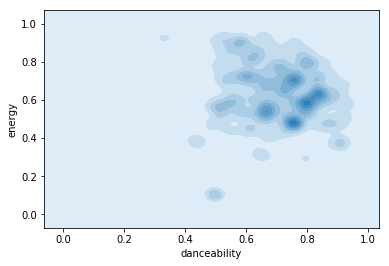

In [65]:
sns.kdeplot(data=track_features_df.dropna().danceability, data2=track_features_df.dropna().energy, shade=True)

In [63]:
plt.show()